# Imports

In [92]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score
from category_encoders.target_encoder import TargetEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
import pandas as pd

# Helper functions

In [13]:
def plot_feature_importance(importance, names, model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data = {
        'feature_names': feature_names,
        'feature_importance': feature_importance
    }
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=True, inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10, 5))

    #Plot bar chart
    plt.barh(fi_df['feature_names'], fi_df['feature_importance'])
    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.tight_layout()

In [14]:
def plot_feature_influence(data: pd.DataFrame, feature, target_var):
    df_ = data.copy()
    fig, ax_left = plt.subplots()
    df_count = df_.groupby([feature])[target_var].count()
    df_mean = df_.groupby([feature])[target_var].mean()

    ax_right = ax_left.twinx()
    ax_left.fill_between(
        df_count.index, 
        0,
        df_count,  # type: ignore
        color="g", 
        alpha=0.2
    )
    ax_left.set_ylabel("{} distribution".format(feature), color="g")

    ax_right.scatter(df_mean.index, df_mean, color="magenta")
    ax_right.set_ylabel("Mean value of {}".format(target_var), color="magenta")
    plt.tight_layout()

In [15]:
def get_scores(X_test, y_test, model):
    mse = mean_squared_error(y_test, model.predict(X_test))
    rmse = np.sqrt(mse)
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))

# Data loading

In [96]:

df_freq: pd.DataFrame = fetch_openml(data_id=41214, as_frame=True).get("data")  # type: ignore
df_sev: pd.DataFrame = fetch_openml(data_id=41215, as_frame=True).get("data")  # type: ignore

df_freq.set_index("IDpol", inplace=True)
df_sev_agg = df_sev.groupby("IDpol").agg(sum)

### Info

In [97]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 678013 entries, 1.0 to 6114330.0
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ClaimNb     678013 non-null  float64 
 1   Exposure    678013 non-null  float64 
 2   Area        678013 non-null  category
 3   VehPower    678013 non-null  float64 
 4   VehAge      678013 non-null  float64 
 5   DrivAge     678013 non-null  float64 
 6   BonusMalus  678013 non-null  float64 
 7   VehBrand    678013 non-null  category
 8   VehGas      678013 non-null  object  
 9   Density     678013 non-null  float64 
 10  Region      678013 non-null  category
dtypes: category(3), float64(7), object(1)
memory usage: 48.5+ MB


In [98]:
df_freq.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [99]:
df_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(2)
memory usage: 416.4 KB


In [100]:
df_sev.describe()

,IDpol,ClaimAmount
count,2.663900e+04,2.663900e+04
mean,2.279864e+06,2.278536e+03
std,1.577202e+06,2.929748e+04
min,1.390000e+02,1.000000e+00
25%,1.087642e+06,6.868100e+02
50%,2.137413e+06,1.172000e+03
75%,3.180162e+06,1.228080e+03
max,6.113971e+06,4.075401e+06


# Data preprocessing

In [101]:
df_claims = df_freq.join(df_sev_agg).fillna(0)

### Visualization

In [102]:
df_claims.describe(percentiles=[0.25, 0.5, 0.75, 0.98, 0.99], include="all")

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
count,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013,6.780130e+05
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN
freq,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601,NaN
mean,0.053247,0.528750,NaN,6.454631,7.044265,45.499122,59.761502,NaN,NaN,1792.422405,NaN,8.835998e+01
std,0.240117,0.364442,NaN,2.050906,5.666232,14.137444,15.636658,NaN,NaN,3958.646564,NaN,5.822454e+03
min,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000e+00
25%,0.000000,0.180000,NaN,5.000000,2.000000,34.000000,50.000000,NaN,NaN,92.000000,NaN,0.000000e+00
50%,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000e+00
75%,0.000000,0.990000,NaN,7.000000,11.000000,55.000000,64.000000,NaN,NaN,1658.000000,NaN,0.000000e+00


array([[<AxesSubplot: title={'center': 'ClaimNb'}>,
        <AxesSubplot: title={'center': 'Exposure'}>,
        <AxesSubplot: title={'center': 'VehPower'}>],
       [<AxesSubplot: title={'center': 'VehAge'}>,
        <AxesSubplot: title={'center': 'DrivAge'}>,
        <AxesSubplot: title={'center': 'BonusMalus'}>],
       [<AxesSubplot: title={'center': 'Density'}>,
        <AxesSubplot: title={'center': 'ClaimAmount'}>, <AxesSubplot: >]],
      dtype=object)

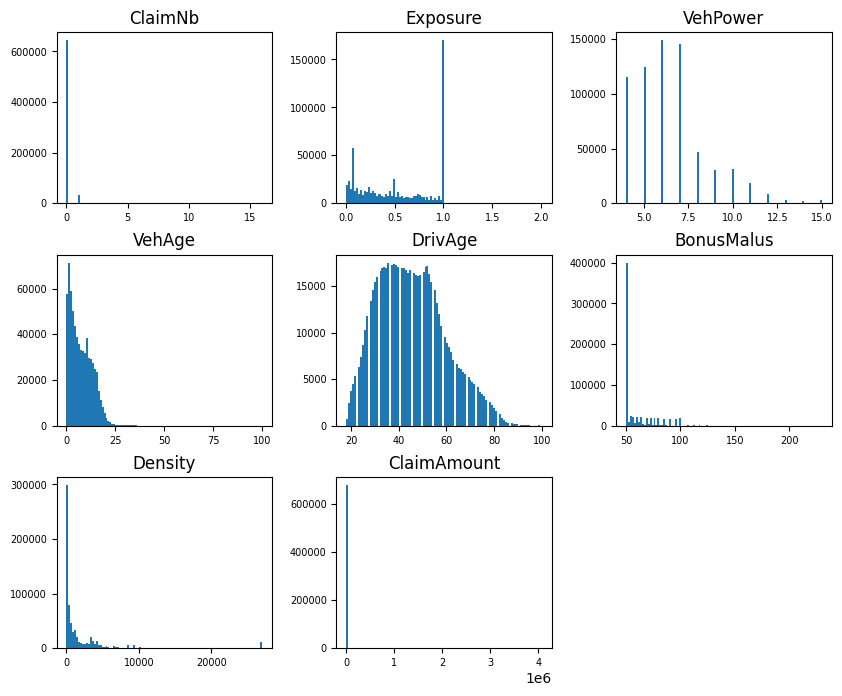

In [23]:
df_claims.hist(figsize=(10, 8), bins=100, grid=False, ylabelsize=7, xlabelsize=7)

In [24]:
df_claims_positive = df_claims[df_claims["ClaimAmount"] > 0]
df_claims_positive.describe(percentiles=[0.25, 0.5, 0.75, 0.98, 0.99, 0.995], include="all")

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
count,24944.000000,24944.000000,24944,24944.000000,24944.000000,24944.000000,24944.000000,24944,24944,24944.000000,24944,2.494400e+04
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,C,NaN,NaN,NaN,NaN,B1,Diesel,NaN,R24,NaN
freq,NaN,NaN,6730,NaN,NaN,NaN,NaN,6509,12700,NaN,6262,NaN
mean,1.060175,0.692669,NaN,6.468970,7.386225,45.139793,64.930164,NaN,NaN,1984.306166,NaN,2.401749e+03
std,0.289929,0.313969,NaN,2.012848,5.173621,14.658487,19.864719,NaN,NaN,4119.719566,NaN,3.026475e+04
min,1.000000,0.002740,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,2.000000,NaN,1.000000e+00
25%,1.000000,0.450000,NaN,5.000000,3.000000,34.000000,50.000000,NaN,NaN,111.000000,NaN,7.497875e+02
50%,1.000000,0.760000,NaN,6.000000,7.000000,45.000000,55.000000,NaN,NaN,495.000000,NaN,1.172000e+03
75%,1.000000,1.000000,NaN,7.000000,11.000000,54.000000,76.000000,NaN,NaN,2120.000000,NaN,1.346400e+03


array([[<AxesSubplot: title={'center': 'ClaimNb'}>,
        <AxesSubplot: title={'center': 'Exposure'}>,
        <AxesSubplot: title={'center': 'VehPower'}>],
       [<AxesSubplot: title={'center': 'VehAge'}>,
        <AxesSubplot: title={'center': 'DrivAge'}>,
        <AxesSubplot: title={'center': 'BonusMalus'}>],
       [<AxesSubplot: title={'center': 'Density'}>,
        <AxesSubplot: title={'center': 'ClaimAmount'}>, <AxesSubplot: >]],
      dtype=object)

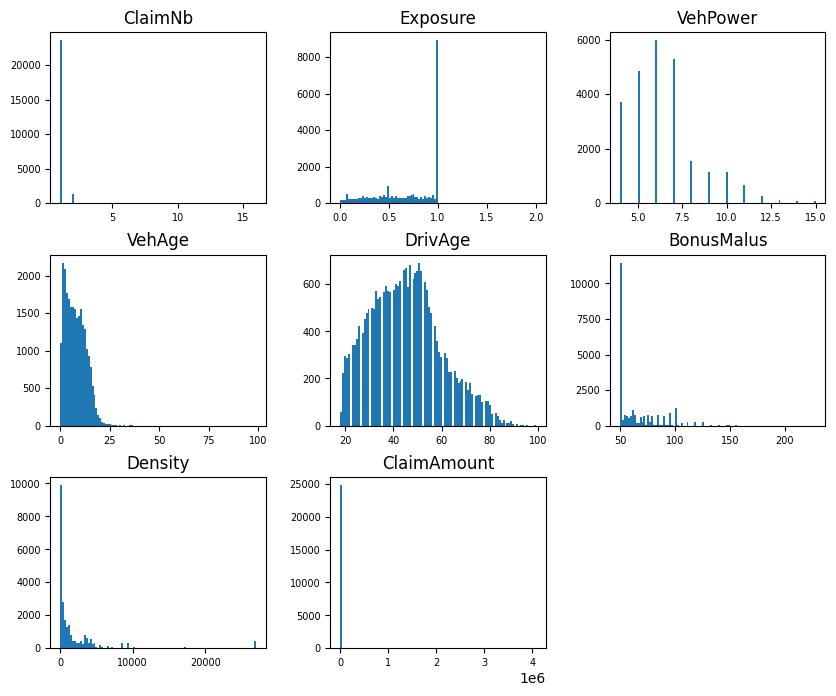

In [25]:
df_claims_positive.hist(figsize=(10, 8), bins=100, grid=False, ylabelsize=7, xlabelsize=7)

### Preprocessing

In [26]:
# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df_claims["ClaimNb"].clip(upper=2, inplace=True)
df_claims["Exposure"].clip(upper=1, inplace=True)
df_claims["ClaimAmount"].clip(upper=35_000, inplace=True)
df_claims["BonusMalus"].clip(upper=125, inplace=True)

In [27]:
df_claims.describe(percentiles=[0.25, 0.5, 0.75, 0.98, 0.99, 0.995], include="all")

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
count,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013,678013.000000
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN
top,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN
freq,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601,NaN
mean,0.053011,0.528545,NaN,6.454631,7.044265,45.499122,59.736981,NaN,NaN,1792.422405,NaN,66.006341
std,0.236119,0.364081,NaN,2.050906,5.666232,14.137444,15.509950,NaN,NaN,3958.646564,NaN,739.095782
min,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000
25%,0.000000,0.180000,NaN,5.000000,2.000000,34.000000,50.000000,NaN,NaN,92.000000,NaN,0.000000
50%,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000
75%,0.000000,0.990000,NaN,7.000000,11.000000,55.000000,64.000000,NaN,NaN,1658.000000,NaN,0.000000


In [28]:
# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df_claims["PurePremium"] = df_claims["ClaimAmount"] / df_claims["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df_claims["Frequency"] = df_claims["ClaimNb"] / df_claims["Exposure"]
df_claims["AvgClaimAmount"] = df_claims["ClaimAmount"] / np.fmax(df_claims["ClaimNb"], 1)

df_claims.fillna(0, inplace=True)

In [29]:
df_claims.describe(percentiles=[0.25, 0.5, 0.75, 0.98, 0.99, 0.995], include="all")

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
count,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013,678013.000000,6.780130e+05,678013.000000,678013.000000
unique,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22,NaN,NaN,NaN,NaN
top,NaN,NaN,C,NaN,NaN,NaN,NaN,B12,Regular,NaN,R24,NaN,NaN,NaN,NaN
freq,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601,NaN,NaN,NaN,NaN
mean,0.053011,0.528545,NaN,6.454631,7.044265,45.499122,59.736981,NaN,NaN,1792.422405,NaN,66.006341,2.682212e+02,0.262739,61.850533
std,0.236119,0.364081,NaN,2.050906,5.666232,14.137444,15.509950,NaN,NaN,3958.646564,NaN,739.095782,1.156071e+04,4.574228,687.416764
min,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.180000,NaN,5.000000,2.000000,34.000000,50.000000,NaN,NaN,92.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000
50%,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000
75%,0.000000,0.990000,NaN,7.000000,11.000000,55.000000,64.000000,NaN,NaN,1658.000000,NaN,0.000000,0.000000e+00,0.000000,0.000000


# Regression

### Frequency Estimation

In [71]:
target_freq = "Frequency"

##### Feature Engineering

In [31]:
df_frequency = df_claims.copy()

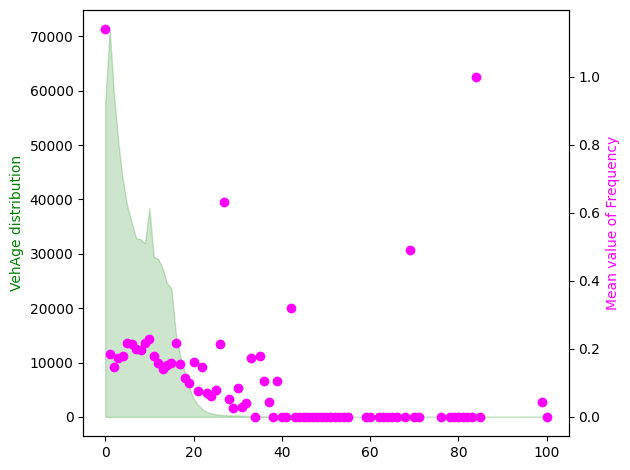

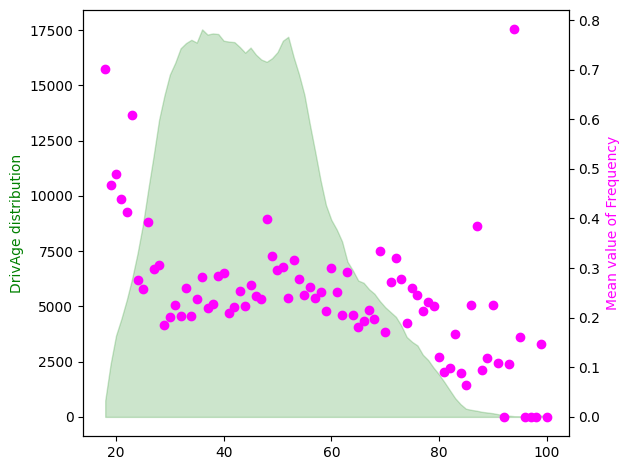

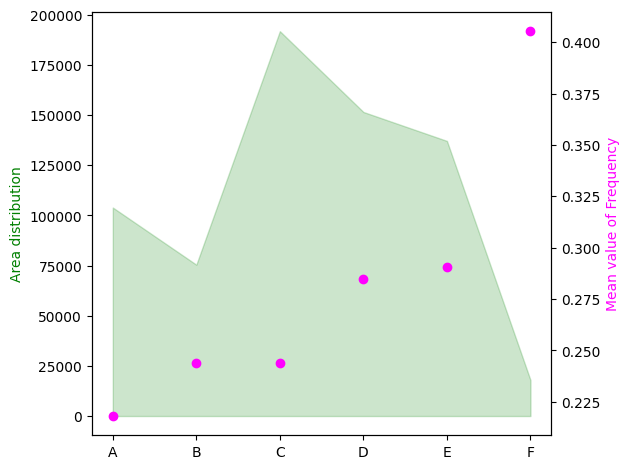

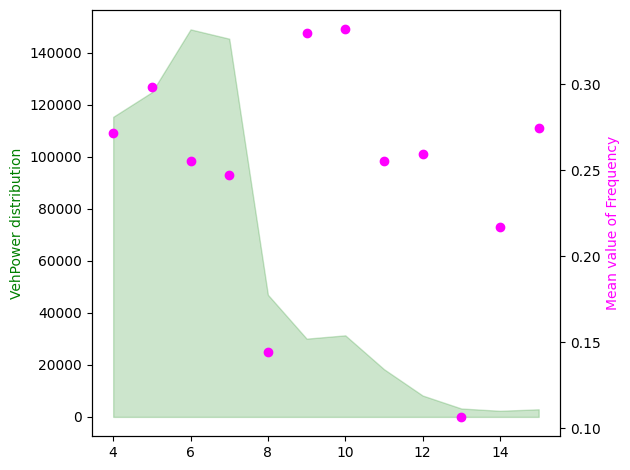

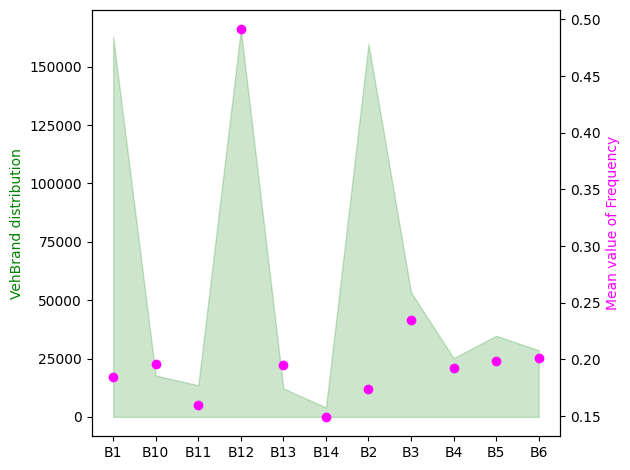

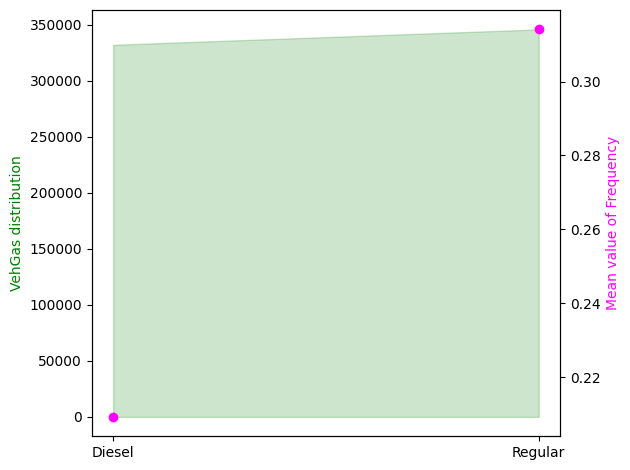

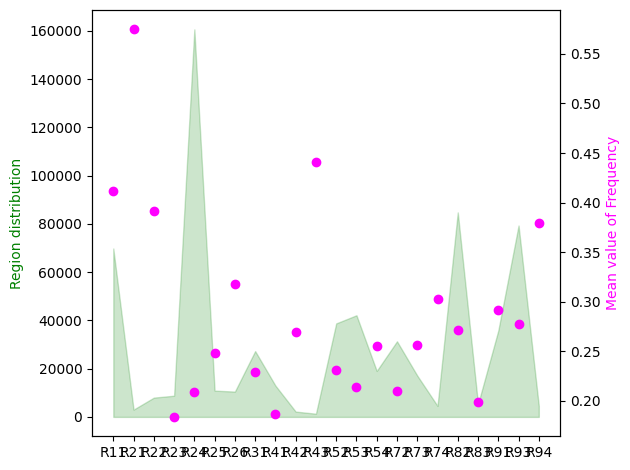

In [32]:
for feature in ["VehAge", "DrivAge", "Area", "VehPower", "VehBrand", "VehGas", "Region"]:
    plot_feature_influence(df_frequency, feature, target_freq)

In [33]:
def prep_frequency_estimation(data: pd.DataFrame):
    df = data.copy()
    for col in ["Region", "Area", "VehBrand"]:
        encoder = TargetEncoder(smoothing=2.0, min_samples_leaf=2)
        df[col] = encoder.fit_transform(df[col], df[target_freq])

    df["DriverAgeGroup"] = pd.cut(df["DrivAge"], [0, 27, 70, 100], labels=["YoungDriver", "AvgAgeDriver", "OldDriver"])
    df["OldVehicle"] = df["VehAge"].apply(lambda x: 1 if x > 17 else 0)
    df["VehGas"] = df["VehGas"].map({"Diesel": 0, "Regular": 1})

    dummies = pd.get_dummies(df["DriverAgeGroup"])
    df = pd.concat([df, dummies], axis=1)
    return df

df_frequency_enc = prep_frequency_estimation(df_frequency)

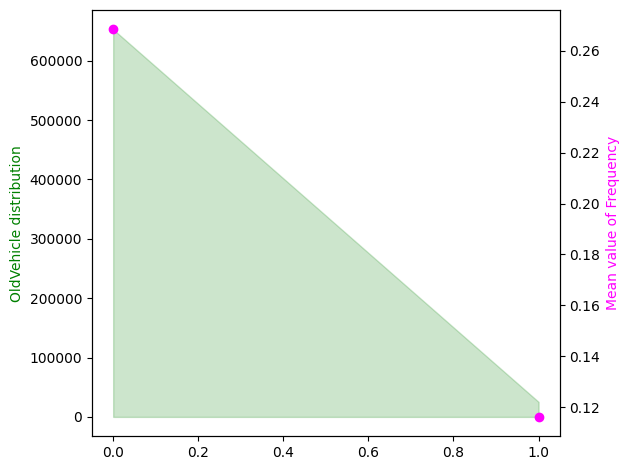

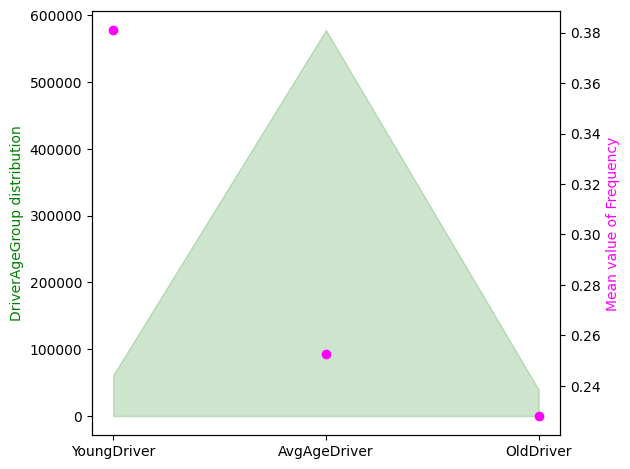

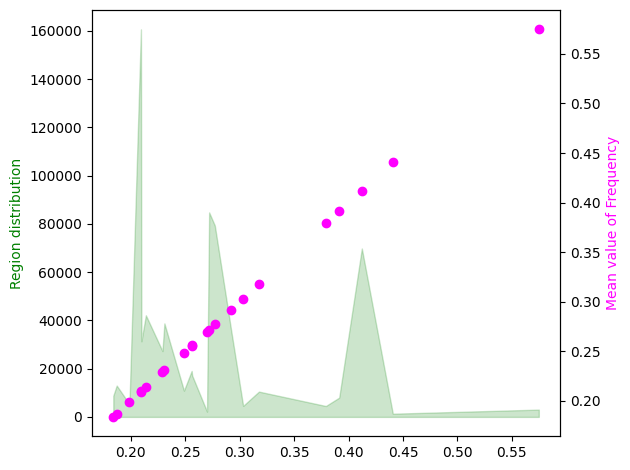

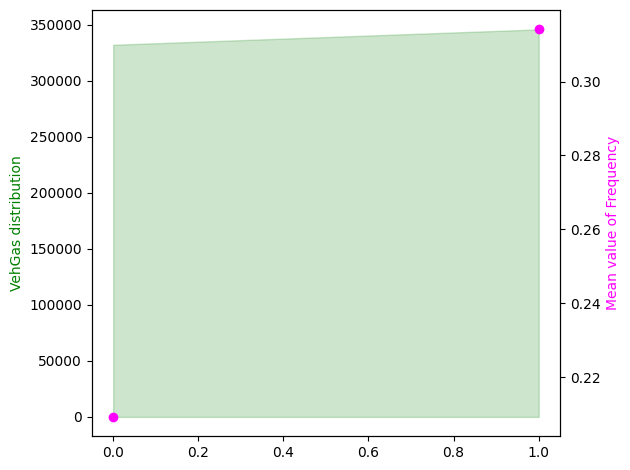

In [34]:
for feature in ["OldVehicle", "DriverAgeGroup", "Region", "VehGas"]:
    plot_feature_influence(df_frequency_enc, feature, target_freq)

##### Feature Selection

In [35]:
features_freq = [
    "OldVehicle",
    "YoungDriver",
    "AvgAgeDriver",
    "OldDriver",
    "BonusMalus",
    "Density",
    "Region",
    "Area",
    "VehGas",
    "VehBrand"
]

<AxesSubplot: >

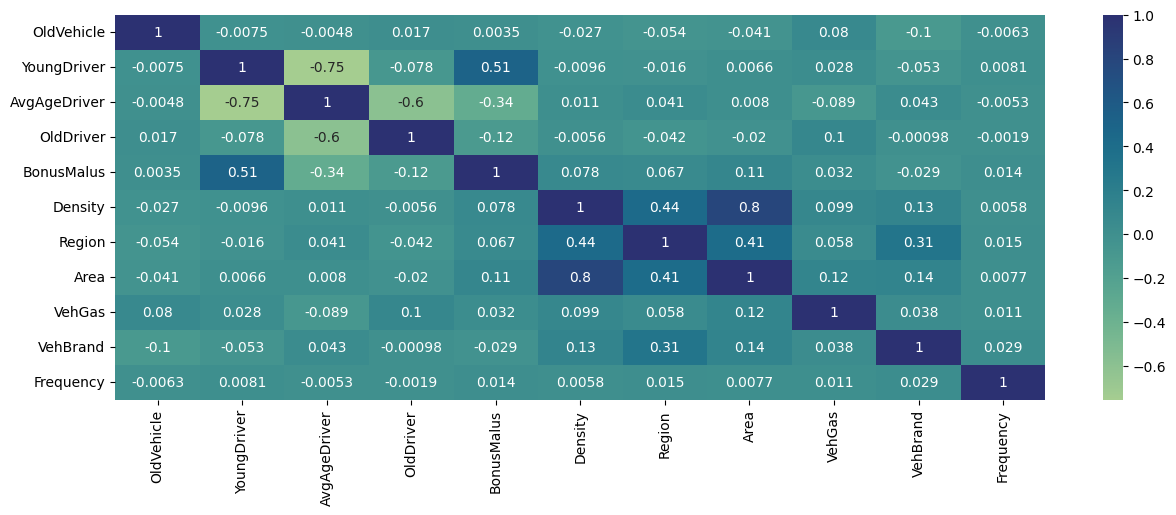

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_frequency_enc[features_freq + [target_freq]].corr(), annot=True, fmt='.2g', cmap="crest")

In [37]:
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    df_frequency_enc[features_freq],
    df_frequency_enc[target_freq],
    df_frequency_enc,
    test_size=0.2
)

##### XGB Regression

In [38]:
xgb_regressor = xgb.XGBRegressor(objective="count:poisson", early_stopping_rounds=20, max_leaves=128)
xgb_regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-poisson-nloglik:1.18201
[1]	validation_0-poisson-nloglik:1.16252
[2]	validation_0-poisson-nloglik:1.14567
[3]	validation_0-poisson-nloglik:1.13288
[4]	validation_0-poisson-nloglik:1.12319
[5]	validation_0-poisson-nloglik:1.11511
[6]	validation_0-poisson-nloglik:1.10836
[7]	validation_0-poisson-nloglik:1.10345
[8]	validation_0-poisson-nloglik:1.09933
[9]	validation_0-poisson-nloglik:1.09656
[10]	validation_0-poisson-nloglik:1.09413
[11]	validation_0-poisson-nloglik:1.09224
[12]	validation_0-poisson-nloglik:1.09114
[13]	validation_0-poisson-nloglik:1.08995
[14]	validation_0-poisson-nloglik:1.08909
[15]	validation_0-poisson-nloglik:1.08816
[16]	validation_0-poisson-nloglik:1.08797
[17]	validation_0-poisson-nloglik:1.08744
[18]	validation_0-poisson-nloglik:1.08735
[19]	validation_0-poisson-nloglik:1.08731
[20]	validation_0-poisson-nloglik:1.08681
[21]	validation_0-poisson-nloglik:1.08691
[22]	validation_0-poisson-nloglik:1.08676
[23]	validation_0-poisson-nloglik:1.08679
[2

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=20, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0.699999988, max_depth=6, max_leaves=128,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='count:poisson', predictor='auto', ...)

In [39]:
get_scores(X_test, y_test, xgb_regressor)

The mean squared error (MSE) on test set: 17.6279
The root mean squared error (RMSE) on test set: 4.1986


<AxesSubplot: >

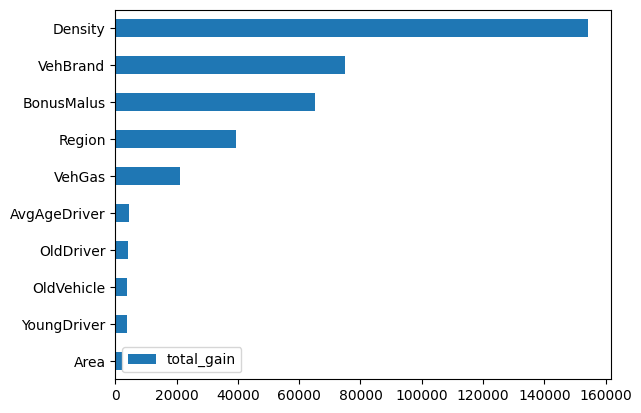

In [40]:
# Get feature importance of each feature. For tree model Importance type can be defined as:

# 'weight': the number of times a feature is used to split the data across all trees.
# 'gain': the average gain across all splits the feature is used in.
# 'cover': the average coverage across all splits the feature is used in.
# 'total_gain': the total gain across all splits the feature is used in.
# 'total_cover': the total coverage across all splits the feature is used in.'
imp_type = "total_gain"
f_importance = xgb_regressor.get_booster().get_score(importance_type=imp_type)
importance_df = pd.DataFrame.from_dict(f_importance, orient="index", columns=[imp_type]).sort_values(by=[imp_type]) 
importance_df.plot.barh()

##### Poisson Regression

In [41]:
glm_freq = PoissonRegressor()
glm_freq.fit(X_train, y_train)

c:\Users\mxja\OneDrive - Deutsche Telekom AG\Workspace\2022_claims_regression\.venv\lib\site-packages\sklearn\linear_model\_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_per_sample + l2_reg_strength * weights


PoissonRegressor()

In [42]:
get_scores(X_test, y_test, glm_freq)

The mean squared error (MSE) on test set: 17.6458
The root mean squared error (RMSE) on test set: 4.2007


### Severity Estimation

In [43]:
target_sev = "AvgClaimAmount"
df_severity = df_claims[df_claims[target_sev] > 0].copy()
df_severity.sample(3)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
2022083.0,1.0,0.89,D,7.0,2.0,48.0,50.0,B12,Diesel,566.0,R93,1172.0,1316.853933,1.123596,1172.0
2012994.0,1.0,0.80,F,9.0,1.0,55.0,50.0,B12,Regular,12374.0,R11,1172.0,1465.000000,1.250000,1172.0
4130052.0,1.0,0.77,D,4.0,4.0,46.0,50.0,B12,Regular,747.0,R53,770.8,1001.038961,1.298701,770.8


##### Feature Engineering

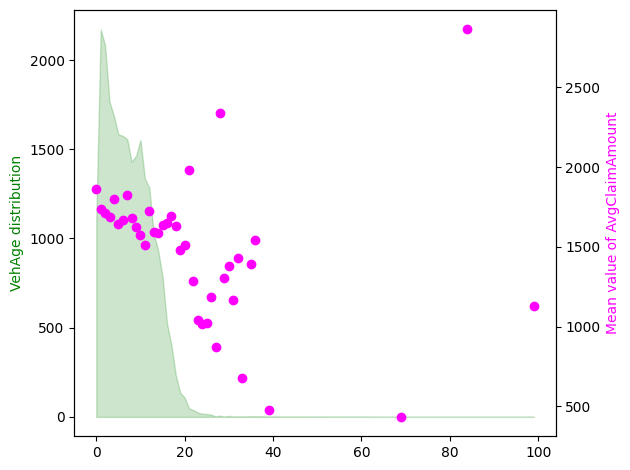

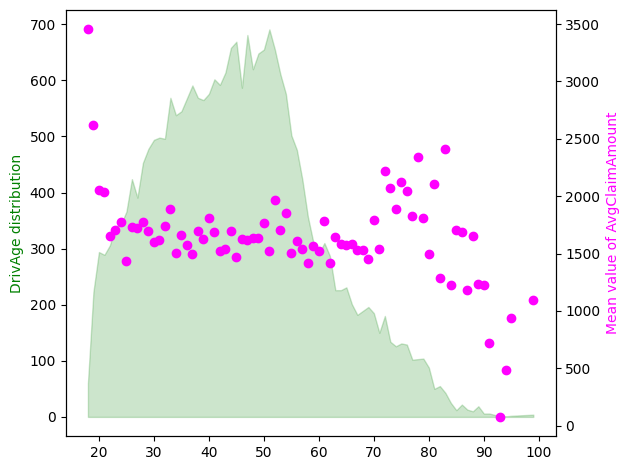

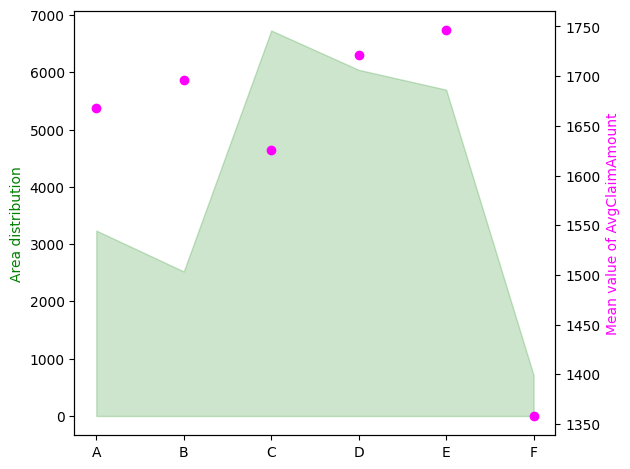

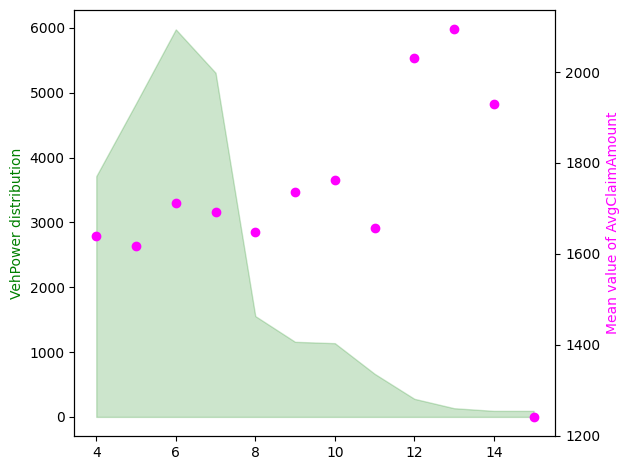

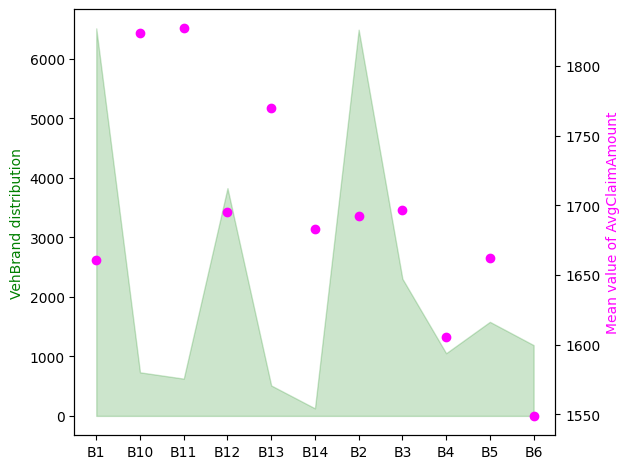

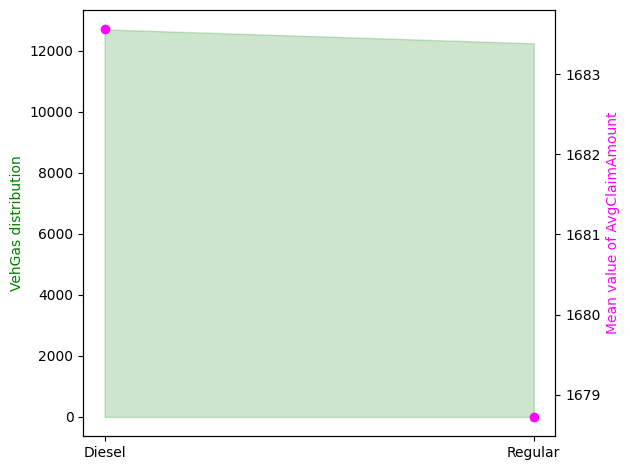

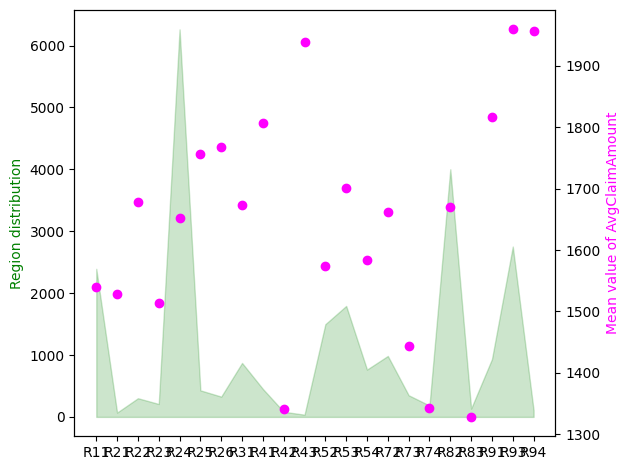

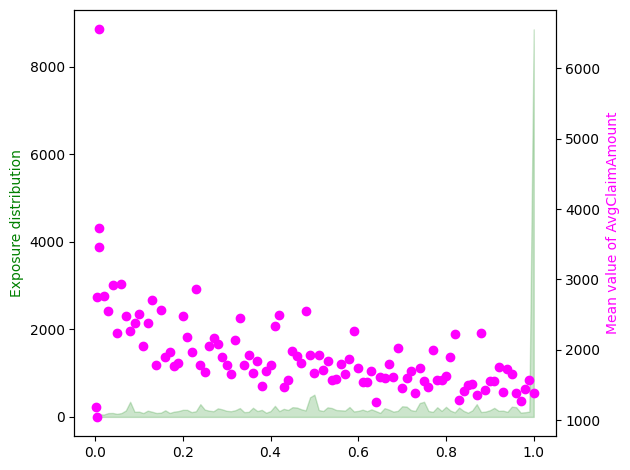

In [44]:
for feature in ["VehAge", "DrivAge", "Area", "VehPower", "VehBrand", "VehGas", "Region", "Exposure"]:
    plot_feature_influence(df_severity, feature, target_sev)

In [65]:
def prep_severity_estimation(data: pd.DataFrame):
    df = data.copy()
    for col in ["Region", "Area", "VehBrand"]:
        encoder = TargetEncoder(smoothing=2.0, min_samples_leaf=2)
        df[col] = encoder.fit_transform(df[col], df[target_sev])

    df["DriverAgeGroup"] = pd.cut(df["DrivAge"], [0, 27, 70, 100], labels=["YoungDriver", "AvgAgeDriver", "OldDriver"])
    df["OldVehicle"] = df["VehAge"].apply(lambda x: 1 if x > 17 else 0)
    df["PowerfulVeh"] = df["VehPower"].apply(lambda x: 1 if x > 8 else 0)

    dummies = pd.get_dummies(df["DriverAgeGroup"])
    df = pd.concat([df, dummies], axis=1)
    return df

df_severity_enc = prep_severity_estimation(df_severity)

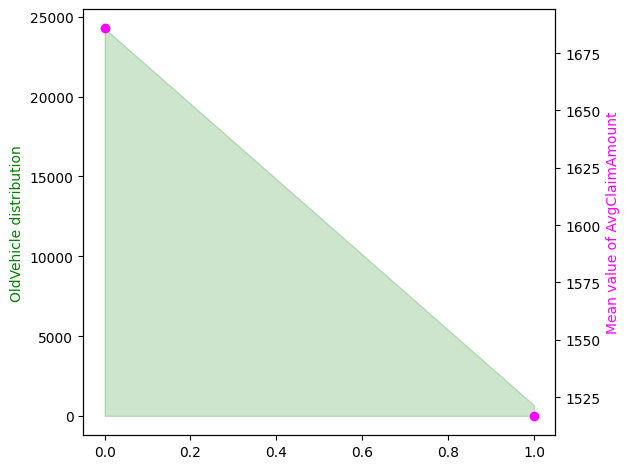

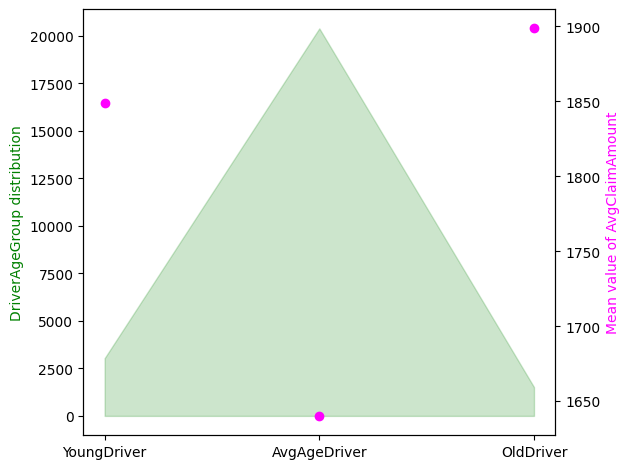

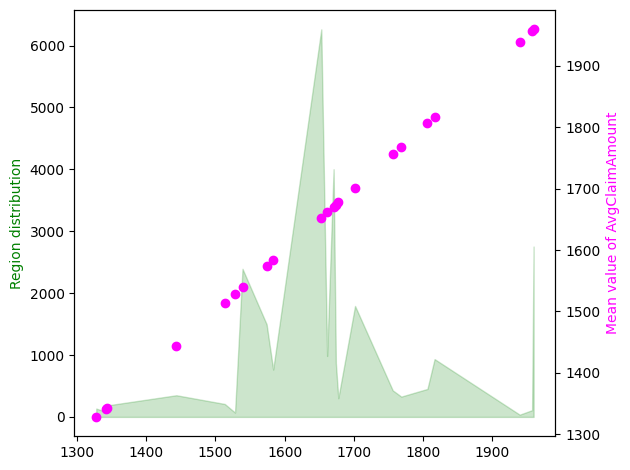

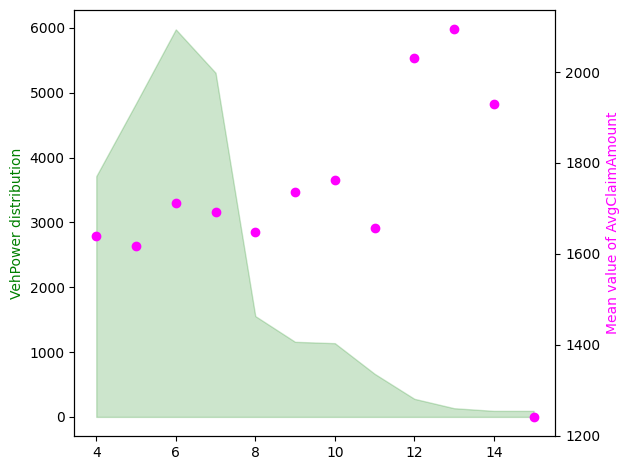

In [66]:
for feature in ["OldVehicle", "DriverAgeGroup", "Region", "VehPower"]:
    plot_feature_influence(df_severity_enc, feature, target_sev)

##### Feature Selection

In [67]:
features_sev = [
    "OldVehicle",
    "YoungDriver",
    "AvgAgeDriver",
    "OldDriver",
    "PowerfulVeh",
    "BonusMalus",
    "Density",
    "Region",
    "Area",
    "VehBrand"
]

<AxesSubplot: >

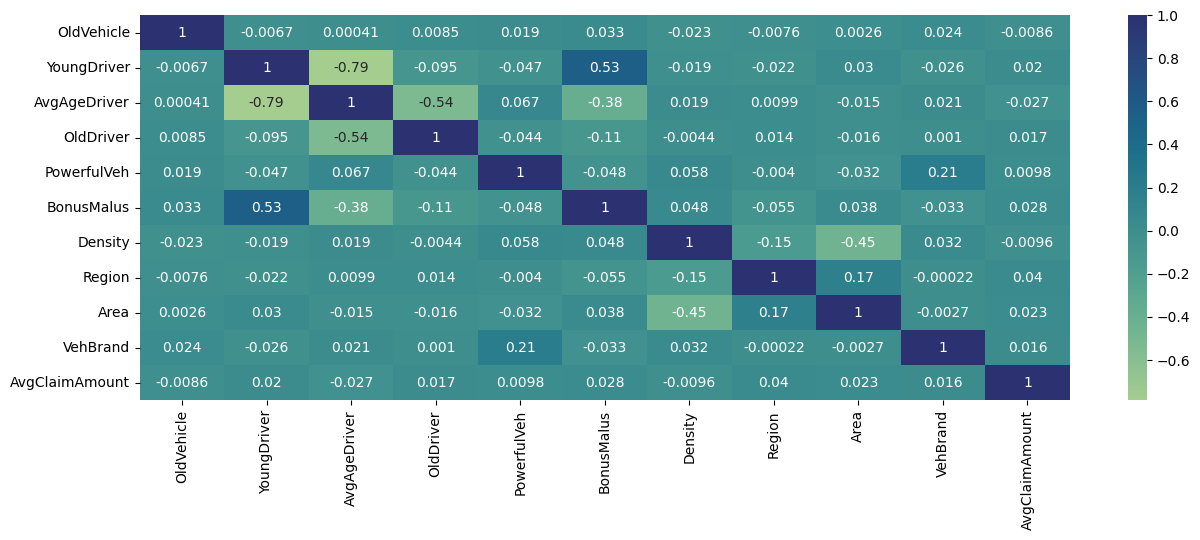

In [68]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_severity_enc[features_sev + [target_sev]].corr(), annot=True, fmt='.2g', cmap="crest")

In [69]:
X_train_sev, X_test_sev, y_train_sev, y_test_sev, df_train_sev, df_test_sev = train_test_split(
    df_severity_enc[features_sev],
    df_severity_enc[target_sev],
    df_severity_enc,
    test_size=0.2
)

##### XGBoost Regression

In [51]:
xgb_sev = xgb.XGBRegressor(objective="reg:gamma", early_stopping_rounds=50, max_leaves=128)
xgb_sev.fit(X_train_sev, y_train_sev, eval_set=[(X_test_sev, y_test_sev)])

[0]	validation_0-gamma-nloglik:2528.07745
[1]	validation_0-gamma-nloglik:1873.27016
[2]	validation_0-gamma-nloglik:1388.25478
[3]	validation_0-gamma-nloglik:1029.02411
[4]	validation_0-gamma-nloglik:762.97707
[5]	validation_0-gamma-nloglik:565.96233
[6]	validation_0-gamma-nloglik:420.08770
[7]	validation_0-gamma-nloglik:312.09856
[8]	validation_0-gamma-nloglik:232.17559
[9]	validation_0-gamma-nloglik:173.04439
[10]	validation_0-gamma-nloglik:129.31590
[11]	validation_0-gamma-nloglik:96.99779
[12]	validation_0-gamma-nloglik:73.13274
[13]	validation_0-gamma-nloglik:55.53095
[14]	validation_0-gamma-nloglik:42.56650
[15]	validation_0-gamma-nloglik:33.03640
[16]	validation_0-gamma-nloglik:26.04946
[17]	validation_0-gamma-nloglik:20.94626
[18]	validation_0-gamma-nloglik:17.23766
[19]	validation_0-gamma-nloglik:14.55809
[20]	validation_0-gamma-nloglik:12.63836
[21]	validation_0-gamma-nloglik:11.27622
[22]	validation_0-gamma-nloglik:10.32361
[23]	validation_0-gamma-nloglik:9.66712
[24]	validat

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=128, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:gamma', predictor='auto', ...)

In [52]:
get_scores(X_test_sev, y_test_sev, xgb_sev)

The mean squared error (MSE) on test set: 10075955.4968
The root mean squared error (RMSE) on test set: 3174.2646


<AxesSubplot: >

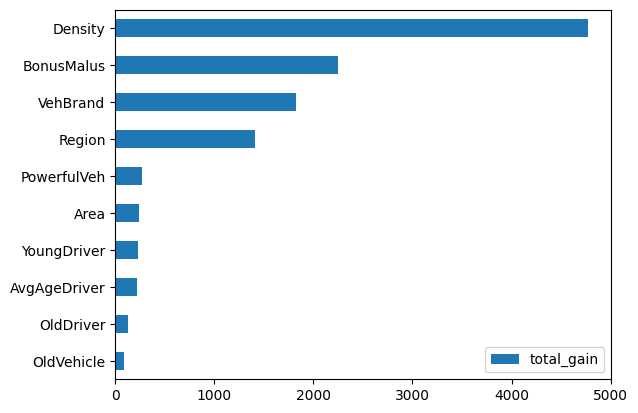

In [53]:
# Get feature importance of each feature. For tree model Importance type can be defined as:

# 'weight': the number of times a feature is used to split the data across all trees.
# 'gain': the average gain across all splits the feature is used in.
# 'cover': the average coverage across all splits the feature is used in.
# 'total_gain': the total gain across all splits the feature is used in.
# 'total_cover': the total coverage across all splits the feature is used in.'
imp_type = "total_gain"
f_importance = xgb_sev.get_booster().get_score(importance_type=imp_type)
importance_df = pd.DataFrame.from_dict(f_importance, orient="index", columns=[imp_type]).sort_values(by=[imp_type]) 
importance_df.plot.barh()

### Pure Premium Estimation

Traditional regression metrics such as Mean Squared Error and Mean Absolute Error are hard to meaningfully interpret on count values with many zeros.

In [91]:
for test_df in [df_claims.copy(), df_claims[df_claims["ClaimAmount"] > 0].copy()]:
    test_df_freq = prep_frequency_estimation(test_df)
    test_df_sev = prep_severity_estimation(test_df)

    pure_premium_estimation = xgb_regressor.predict(test_df_freq[features_freq]) * xgb_sev.predict(test_df_sev[features_sev])
    pure_premium_observed = test_df["PurePremium"]

    print(f"MSE: {mean_squared_error(pure_premium_observed, pure_premium_estimation)}")
    print(f"Sum observed Pure Premium: {np.sum(pure_premium_observed)}")
    print(f"Sum estimated Pure Premium: {np.sum(pure_premium_estimation)}")

MSE: 133496853.8372999
Sum observed Pure Premium: 181857457.01550162
Sum estimated Pure Premium: 203461792.0
MSE: 3614636563.2543
Sum observed Pure Premium: 181857457.0155017
Sum estimated Pure Premium: 28620042.0


# Classification

In [54]:
target = "ClaimIncident"

data_classification = df_claims.copy()
data_classification[target] = data_classification["ClaimAmount"].apply(lambda val: 1 if val > 0 else 0)

In [55]:
data_classification.groupby(target, group_keys=False).apply(lambda df: df.sample(2))

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount,ClaimIncident
IDpol,,,,,,,,,,,,,,,,
9251.0,1.0,0.16,C,10.0,5.0,44.0,50.0,B12,Regular,126.0,R41,0.00,0.000000,6.250000,0.00,0
18060.0,1.0,0.38,A,8.0,9.0,49.0,50.0,B1,Diesel,11.0,R82,0.00,0.000000,2.631579,0.00,0
23097.0,1.0,1.00,C,5.0,1.0,45.0,68.0,B2,Regular,481.0,R82,1128.12,1128.120000,1.000000,1128.12,1
4024225.0,1.0,0.71,E,6.0,10.0,53.0,72.0,B12,Regular,3374.0,R42,313.21,441.140845,1.408451,313.21,1


### Feature Engineering

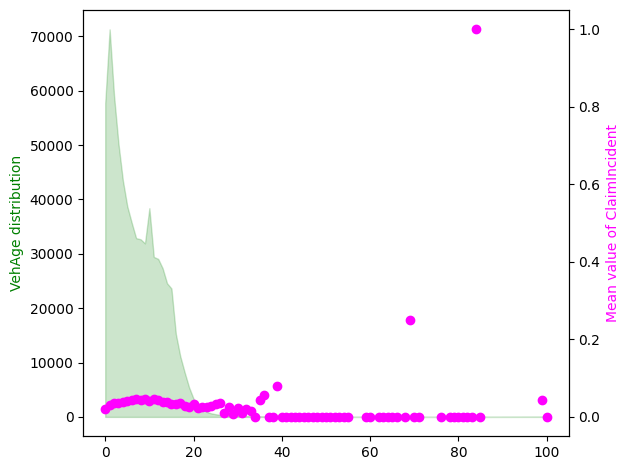

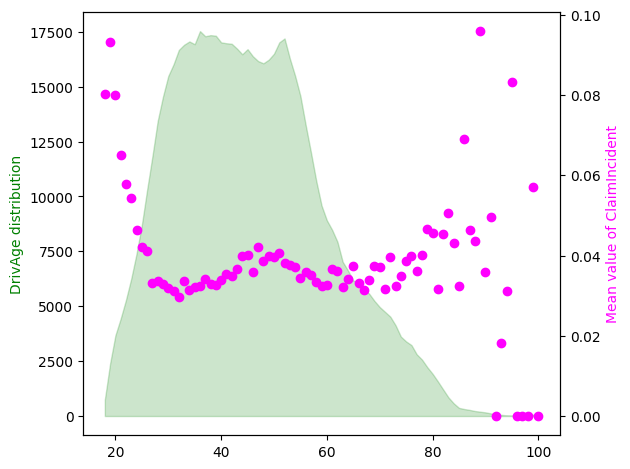

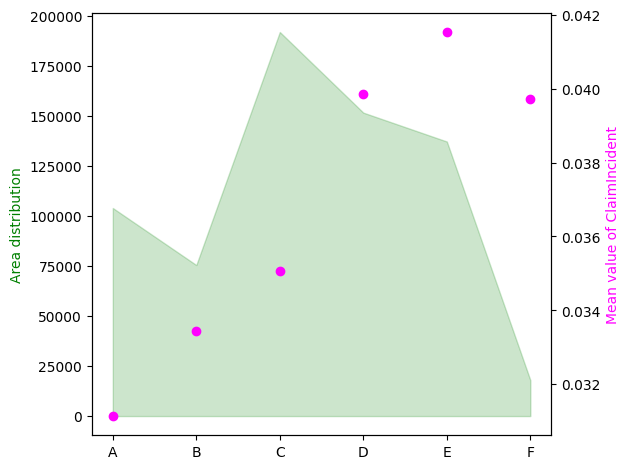

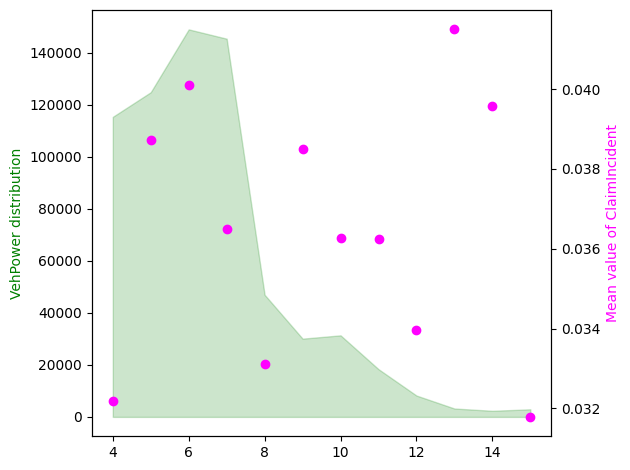

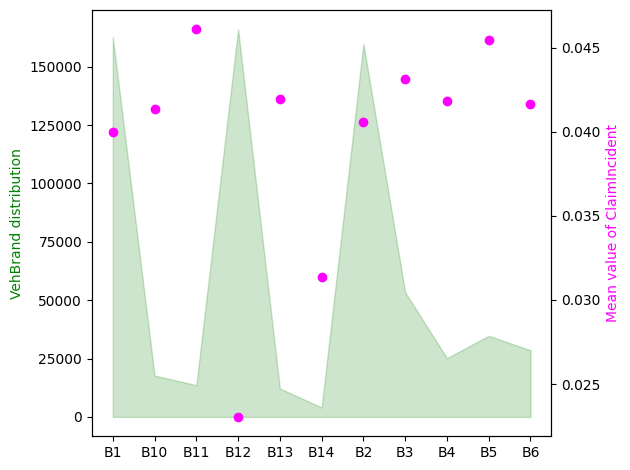

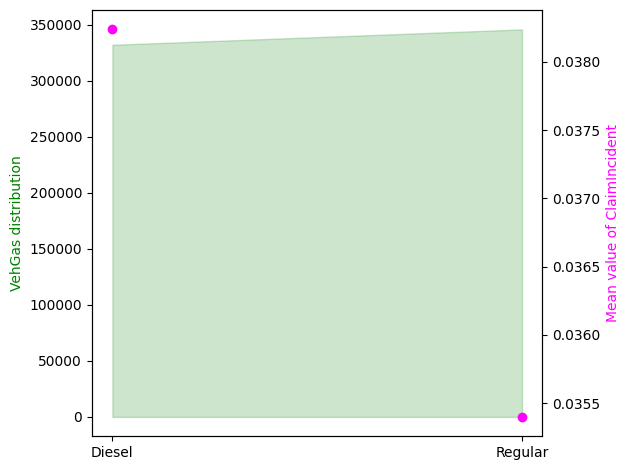

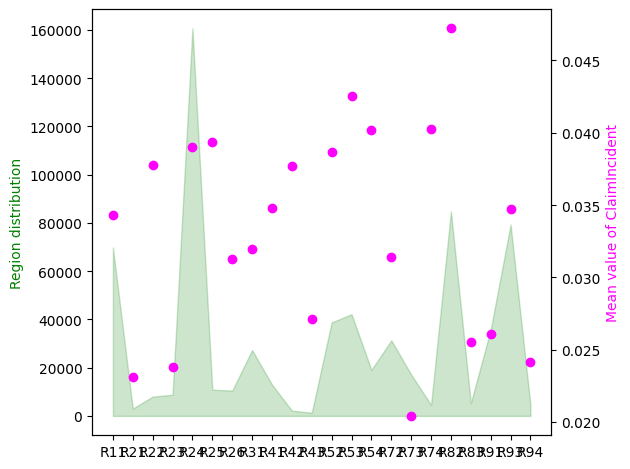

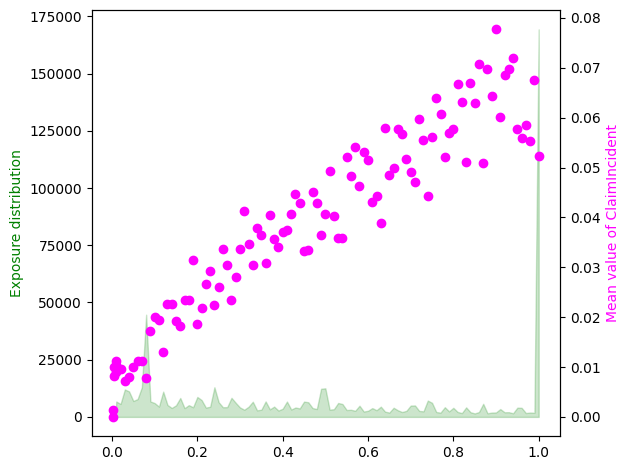

In [56]:
for feature in ["VehAge", "DrivAge", "Area", "VehPower", "VehBrand", "VehGas", "Region", "Exposure"]:
    plot_feature_influence(data_classification, feature, target)

In [57]:
xgb_class_data = data_classification.copy()

for col in ["Region", "VehGas", "Area", "VehBrand"]:
    encoder = TargetEncoder(smoothing=2.0, min_samples_leaf=2)
    xgb_class_data[col] = encoder.fit_transform(xgb_class_data[col], xgb_class_data[target])

xgb_class_data["DriverAgeGroup"] = pd.cut(xgb_class_data["DrivAge"], [0, 27, 70, 100], labels=["YoungDriver", "AvgAgeDriver", "OldDriver"])
xgb_class_data["VehAgeGroup"] = pd.cut(xgb_class_data["VehAge"], [-1, 2, 20, 100], labels=["NewVeh", "AvgAgeVeh", "OldVeh"])

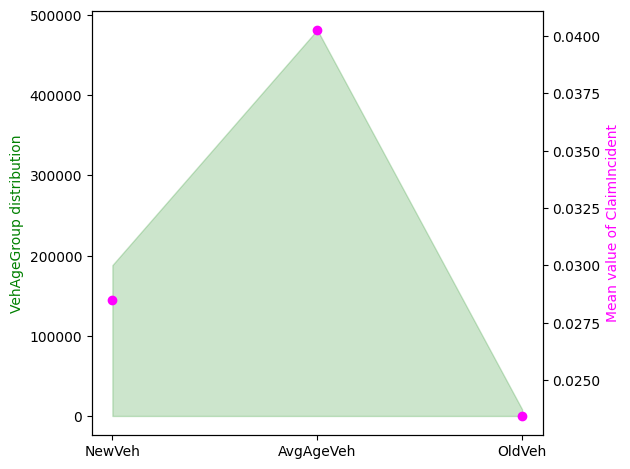

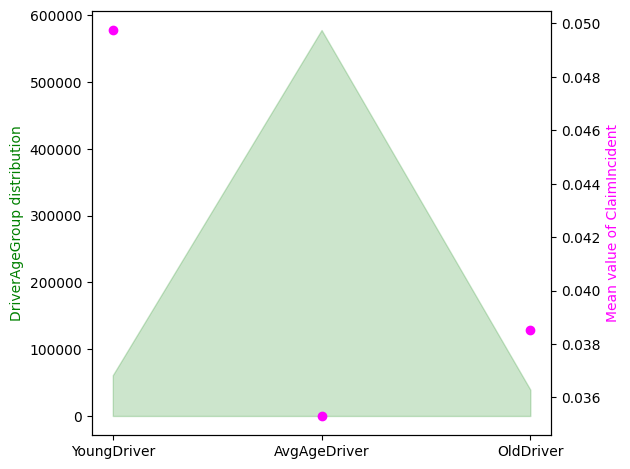

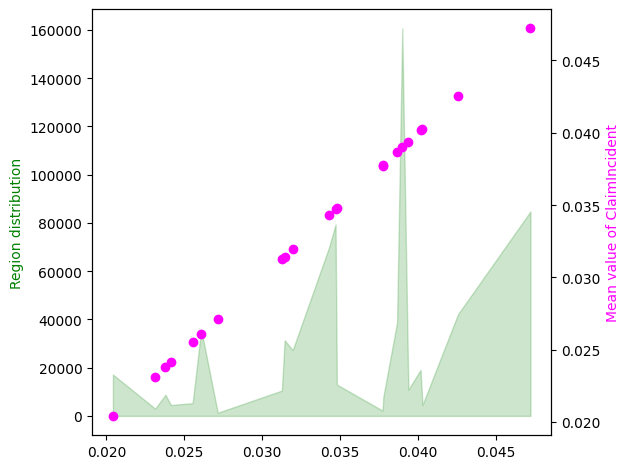

In [58]:
plot_feature_influence(xgb_class_data, "VehAgeGroup", target)
plot_feature_influence(xgb_class_data, "DriverAgeGroup", target)
plot_feature_influence(xgb_class_data, "Region", target)

In [59]:
dummies_driv_age = pd.get_dummies(xgb_class_data["DriverAgeGroup"])
dummies_veh_age = pd.get_dummies(xgb_class_data["VehAgeGroup"])

new = pd.concat([xgb_class_data, dummies_driv_age, dummies_veh_age], axis=1)

### Feature Selection

In [60]:
features = [
    "NewVeh",
    "AvgAgeVeh",
    "OldVeh",
    "YoungDriver",
    "AvgAgeDriver",
    "OldDriver",
    "VehPower",
    "BonusMalus",
    "Density",
    "Region",
    "Area",
    "VehBrand"
]

In [61]:
data_claim = new[new[target] == 1]
data_no_claim = new[new[target] == 0].sample(3 * data_claim.shape[0])

data_classification_balanced = pd.concat([data_claim, data_no_claim])

X_train_te, X_test_te, y_train_te, y_test_te = train_test_split(new[features], new[target], random_state=0, test_size=0.1)

<AxesSubplot: >

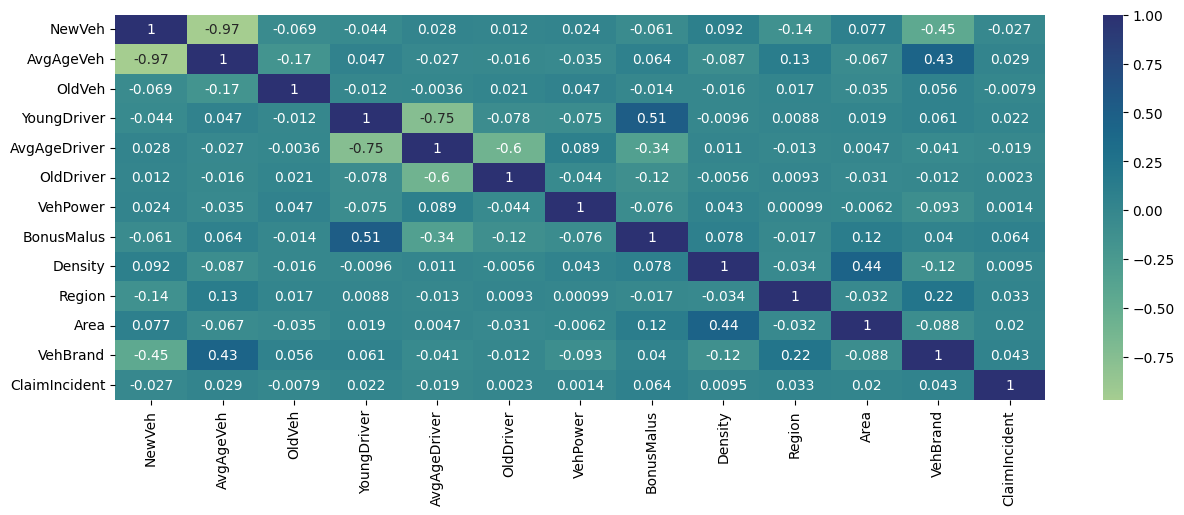

In [62]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(new[features + [target]].corr(), annot=True, fmt='.2g', cmap="crest")

### XGBoost Classifier

In [63]:
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", early_stopping_rounds=10, scale_pos_weight=1, min_child_weight=1)
xgb_classifier.fit(X_train_te, y_train_te, eval_set=[(X_test_te, y_test_te)])
f1_score(y_test_te, xgb_classifier.predict(X_test_te))

[0]	validation_0-logloss:0.47306
[1]	validation_0-logloss:0.35334
[2]	validation_0-logloss:0.28047
[3]	validation_0-logloss:0.23392
[4]	validation_0-logloss:0.20375
[5]	validation_0-logloss:0.18415
[6]	validation_0-logloss:0.17130
[7]	validation_0-logloss:0.16319
[8]	validation_0-logloss:0.15812
[9]	validation_0-logloss:0.15488
[10]	validation_0-logloss:0.15304
[11]	validation_0-logloss:0.15171
[12]	validation_0-logloss:0.15099
[13]	validation_0-logloss:0.15066
[14]	validation_0-logloss:0.15036
[15]	validation_0-logloss:0.15024
[16]	validation_0-logloss:0.15018
[17]	validation_0-logloss:0.15004
[18]	validation_0-logloss:0.15001
[19]	validation_0-logloss:0.14990
[20]	validation_0-logloss:0.14991
[21]	validation_0-logloss:0.14990
[22]	validation_0-logloss:0.14986
[23]	validation_0-logloss:0.14982
[24]	validation_0-logloss:0.14983
[25]	validation_0-logloss:0.14985
[26]	validation_0-logloss:0.14982
[27]	validation_0-logloss:0.14982
[28]	validation_0-logloss:0.14981
[29]	validation_0-loglos

0.0008123476848090984

In [64]:
print(classification_report(y_test_te, xgb_classifier.predict(X_test_te)))
print(confusion_matrix(y_test_te, xgb_classifier.predict(X_test_te)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     65346
           1       0.17      0.00      0.00      2456

    accuracy                           0.96     67802
   macro avg       0.57      0.50      0.49     67802
weighted avg       0.93      0.96      0.95     67802

[[65341     5]
 [ 2455     1]]
